In [1]:
# Importing Libraries
#For Data Cleansing
import pandas as pd
import numpy as np
import json

#For data ingetion through API
import requests as req

#For visualisation
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#For supressing warnings
import warnings

In [2]:
#Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
#Generic function to convert csv into dataframe
def readFile(fileName):
    df= pd.read_csv(fileName)
    return df

#Generic function to convert csv into Numpy Array
def readFileAsNumpy(fileName,delimiter=','):
    data = np.genfromtxt(fileName, delimiter=delimiter)
    return data


In [4]:
#Extracting history of the Stock Symbol from Alpha Vantage through API
def getStockHistory(symbol):
    #AlphaVantage provides a free API registration functionality. 
    #Free tier allows for 5 calls per min and 500 calls per day
    apikey="8F2RGPNPOLZKRID1"
    
    #The parameters to AlphaVantage API needs to be passed as part of URL
    url ="https://www.alphavantage.co/query"
    url ="https://www.alphavantage.co/query?"
    url = url + "function=TIME_SERIES_WEEKLY_ADJUSTED"
    url = url + "&symbol=" + symbol
    url = url + "&outputsize=full"
    url = url + "&apikey=" + apikey
    
    #Hitting API to extract the data. We are going with full data for past 10 years
    resp=req.get(url)
    if resp.status_code==200:
        try:
            result=resp.json()
            print("Extracting data for Symbol - ",symbol)
            df=pd.DataFrame.from_dict(result["Weekly Adjusted Time Series"],orient='index')

            #Dropping columns we don't need for this module
            df=df.drop(['1. open','2. high','3. low'],axis=1)
            df=df.drop(['5. adjusted close','7. dividend amount'],axis=1)
            
            #Renaming columns to make more sense
            df.rename(columns = {'4. close':'CLOSE_PRICE', '6. volume':'VOLUME'}, inplace = True)
            
            #Reseting index and making Date a column
            df = df.reset_index()
            
            df.rename(columns = {'index':'Date'}, inplace = True)
            
            #Converting Close Price to float value
            df["CLOSE_PRICE"] = df["CLOSE_PRICE"].apply(pd.to_numeric)
            
            #Adding the symbol name to the dataframe
            df=df.assign(SYMBOL=symbol)
            
            #Saving the massaged data into a file
            #This will be used in case API becomes unavailable due to above highlighted limitations
            df.to_csv("Dataset/" + symbol + ".csv")
        except:
            print("Error while connecting to API. Reading from file...")
            #API data unavaialble due to some reasons. Reverting to using previously stored data
            df=readFile("Dataset/" + symbol + ".csv")
        
        return df
    else:
        return pandas.DataFrame()

    

In [5]:
#Collating the stock data history for multiple stocks into a single data frame
def createStockListDataFrame(dataFrame,startDate):
    #Create blank Dataframe
    stockDataFrame=pd.DataFrame()
    
    #Iterate through each symbol in the list
    for symbol in dataFrame['SYMBOL']:
        print("Getting history for symbol ",symbol)
        #Extract stock price history for the symbol
        df=getStockHistory(symbol)
        #Convert Date column into Date format
        df["Date"] = pd.to_datetime(df["Date"]).dt.strftime('%Y-%m-%d')
        
        #Limiting the data to process
        df=df.loc[df['Date']>startDate]
        
        #If data was found (lenght of dataframe is not 0), merge with the overall DataFrame
        if len(df)>0:
            print("Data returned for symbol ",symbol )
            stockDataFrame=stockDataFrame.append(df,ignore_index=True)
    
    #Return the full dataset
    return stockDataFrame


In [6]:
#To help claculate relative strength of a stock. 
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

In [14]:
#Creating a heatmap of all stocks against the date. 
#This is to present a better view of how the stocks have been doing over time.
def heatMapChart(dataFrame,title):
    # Draw a heatmap with the numeric values in each cell
    data=dataFrame.pivot(index='Date',columns='SYMBOL',values='RSI')
    f, ax = plt.subplots(figsize=(9, 6))
    sns.heatmap(data, annot=False, fmt="",cmap='RdYlGn',linewidths=.5, ax=ax).set(title=title)
    
    
#Creating a visually appealing line chart of all stocks against the date. 
#This is to present a better view of how the stocks have been doing over time.
def plotlyLineChart1(dataFrame1,dataFrame2):
    fig, ax = plt.subplots(nrows=1,ncols=2,sharex=True,sharey=True)
    
    for symbol in dataFrame1['SYMBOL'].unique():
        print("Plotting for symbol - ",symbol)
        df1=dataFrame1[(dataFrame1['SYMBOL']==symbol)]
        ax[0].plot(df1['Date'],df1['RSI'],label=symbol )
    
    
    for symbol in dataFrame2['SYMBOL'].unique():
        print("Plotting for symbol - ",symbol)
        df2=dataFrame2[(dataFrame2['SYMBOL']==symbol)]
        ax[1].plot(df2['Date'],df2['RSI'],label=symbol )

    
    ax[0].set_xticklabels(dataFrame1['Date'], rotation=50)
    ax[1].set_xticklabels(dataFrame2['Date'], rotation=50)
    fig.set_figwidth(20) 
    fig.legend()
    plt.show()
    
def plotlyLineChart(dataFrame1,title):
    fig = px.line(dataFrame1, x='Date', y='RSI', color='SYMBOL')
    fig.update_layout(title_text=title)
    fig.show()

def plotlyLinePlot(dataFrame,title):
    
    fig, ax = plt.subplots()
    
    for symbol in dataFrame['SYMBOL'].unique():
        print("Plotting for symbol - ",symbol)
        df1=dataFrame[(dataFrame['SYMBOL']==symbol)]
        ax.plot(df1['Date'],df1['RSI'],label=symbol )
    
    ax.set_xticklabels(dataFrame['Date'], rotation=50)
    
    plt.title(title)
    fig.set_figwidth(20) 
    fig.legend()
    plt.show()


Extracting information for Portfolio Stocks
Getting history for symbol  INFY
Extracting data for Symbol -  INFY
Data returned for symbol  INFY
Getting history for symbol  AAPL
Extracting data for Symbol -  AAPL
Data returned for symbol  AAPL
Getting history for symbol  MSFT
Extracting data for Symbol -  MSFT
Data returned for symbol  MSFT
Getting history for symbol  AMZN
Extracting data for Symbol -  AMZN
Data returned for symbol  AMZN
          Date  CLOSE_PRICE     VOLUME SYMBOL STOCK_TYPE        RSI
63  2022-08-05       140.80  331869002   AMZN  Portfolio  46.727067
31  2022-08-05       165.35  322415021   AAPL  Portfolio  77.811232
15  2022-08-05        20.31   36700519   INFY  Portfolio  61.455111
47  2022-08-05       282.91  102685912   MSFT  Portfolio  74.480490
14  2022-08-12        20.11   32980499   INFY  Portfolio  60.156897
Extracting information for WatchList Stocks
Getting history for symbol  NVDA
Extracting data for Symbol -  NVDA
Data returned for symbol  NVDA
Getting h

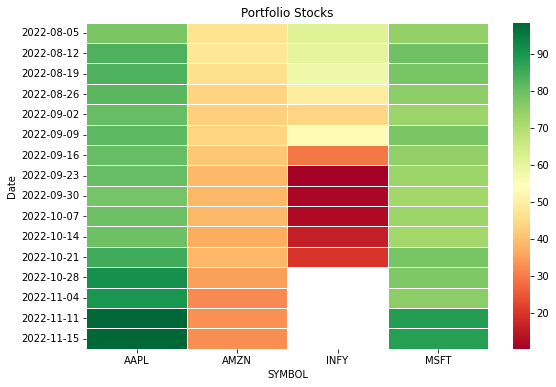

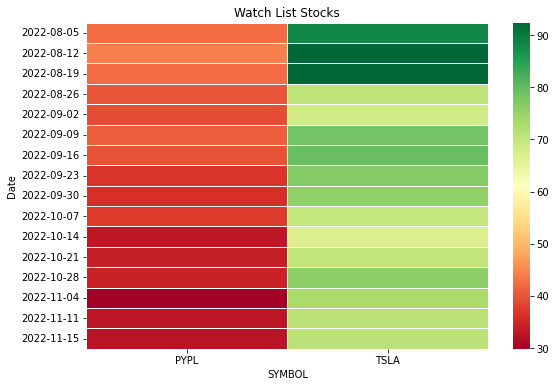

In [15]:
if __name__ == '__main__':

    startDate="2022-07-31"
    #Read the stocks held in the portfolio
    df_port=readFile("DataSet/Portfolio.csv")
    
    #Read the stocks in watchlist
    df_wl=readFile("DataSet/WatchList.csv")

    #Buidling DataFrame for all the protfolio stocks. 
    print("Extracting information for Portfolio Stocks")
    portfolioStocks=createStockListDataFrame(df_port,startDate)
    portfolioStocks['STOCK_TYPE']="Portfolio"
    
    #Calculating RSI for each stock
    portfolioStocks['RSI'] = get_rsi(portfolioStocks['CLOSE_PRICE'], 14)
    
    #Dropping NA values
    portfolioStocks = portfolioStocks.dropna()
    
    #Sorting by date in descending for effective charting
    portfolioStocks = portfolioStocks.sort_values(by = ['Date'],ascending=True)
    
    print(portfolioStocks.head())
    
    #------------------------------------------------------------------
    #Repeating the steps for WatchList stocks
    #------------------------------------------------------------------
    print("Extracting information for WatchList Stocks")
    WLStocks=createStockListDataFrame(df_wl,startDate)
    WLStocks['STOCK_TYPE']="WatchList"
    WLStocks['RSI'] = get_rsi(WLStocks['CLOSE_PRICE'], 14)
    WLStocks = WLStocks.dropna()
    WLStocks = WLStocks.sort_values(by = ['Date'],ascending=True)
    #------------------------------------------------------------------
    
    
    #Extracting the index data that has been previously stored in form of a CSV file.
    print("Reading NASDAQ Data - ")
    idxHistory = readFile("DataSet/NASDAQ Data.csv")
    
    #Renaming columns for better understanding
    idxHistory.rename(columns = {'Adj Close':'IDX_CLOSE'},inplace = True)
    
    #Adding symbol for the index
    idxHistory['SYMBOL']='NASDAQ'
    
    #Calculating Index RSI
    idxHistory['RSI'] = get_rsi(idxHistory['IDX_CLOSE'], 14)
    
   # idxHistory=idxHistory.drop(idxHistory[(idxHistory['Weekday']!=4)])
    
    #print(idxHistory.head(50))
        
    #Sorting based on Date
    idxHistory = idxHistory.sort_values(by = ['Date'],ascending=True)
    
    #Extracting data after the start date
    idxHistory=idxHistory[(idxHistory['Date']>startDate)]
    
    #Plotting Line Chart for the Portfolio Stocks
    plotlyLineChart(portfolioStocks,"Relative Strength of Portfolio Stocks")
    
    #Plotting Line Chart for the Watch list Stocks
    plotlyLineChart(WLStocks,"Relative Strength of Watch List Stocks")
    
    #Plotting Line Chart for the NASDAQ Index
    plotlyLineChart(idxHistory,"Relative Strength of the Index - NASDAQ")
    
    heatMapChart(portfolioStocks,"Portfolio Stocks")
    heatMapChart(WLStocks,"Watch List Stocks")